# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [1]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt
#----------------------------------------------------------------------------------------------------------------
from datasets.kitti_dataset import KITTIDataset
#----------------------------------------------------------------------------------------------------------------

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

c:\Users\tuoma\miniconda3\envs\kikkeli\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setting up network and loading weights

In [2]:
model_name = "mono_640x192"

download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [3]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size


feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)
#----------------------------------------------------------------------------------------------------------------
input_image_cut = KITTIDataset.get_Cut_Flip(input_image)
#----------------------------------------------------------------------------------------------------------------

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0)

## Prediction using the PyTorch model

In [4]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

c:\Users\tuoma\miniconda3\envs\kikkeli\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## Plotting

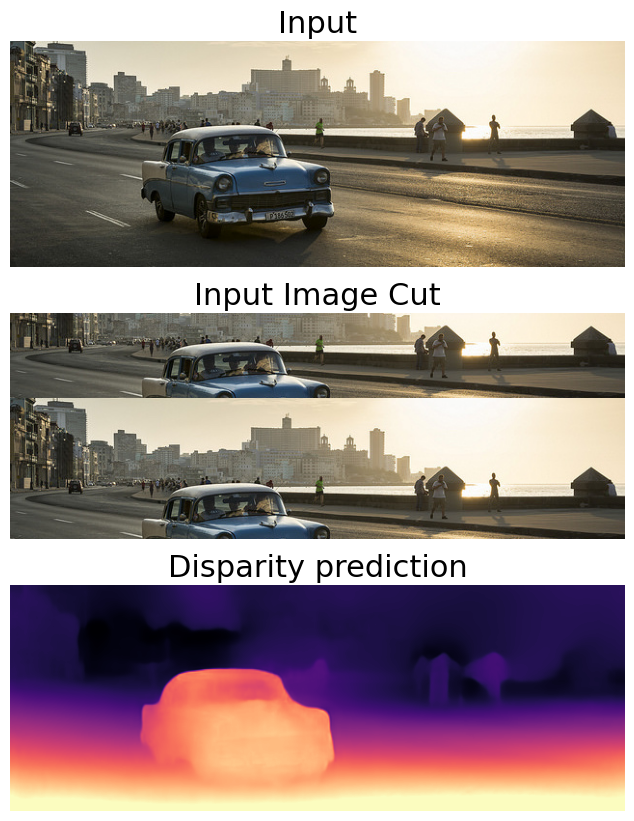

In [5]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(311)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(312)
plt.imshow(input_image_cut)
plt.title("Input Image Cut", fontsize=22)
plt.axis('off')

plt.subplot(313)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');